# Seurat pipeline

In [13]:
library(Seurat)
library(tidyverse)
library(cowplot)
library(DropletUtils)
library(clustree)

-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.3     v readr     2.1.4
v forcats   1.0.0     v stringr   1.5.0
v lubridate 1.9.3     v tibble    3.2.1
v purrr     1.0.2     v tidyr     1.3.0
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: 'cowplot'


The following object is masked from 'package:lubridate':

    stamp


Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: 'matrixStats'


The following object is masked from 'package:dplyr':

    count



Attaching package: 'MatrixGenerics'


The following objects are masked from 'package:matrixStats':

    colAlls, colA

## A549 dataset pre-process

In [2]:
load('./sci-CAR_analysis-master/Data/A549_RNAseq_cell_gene_gene_count.RData')

Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 1.1 GiB"


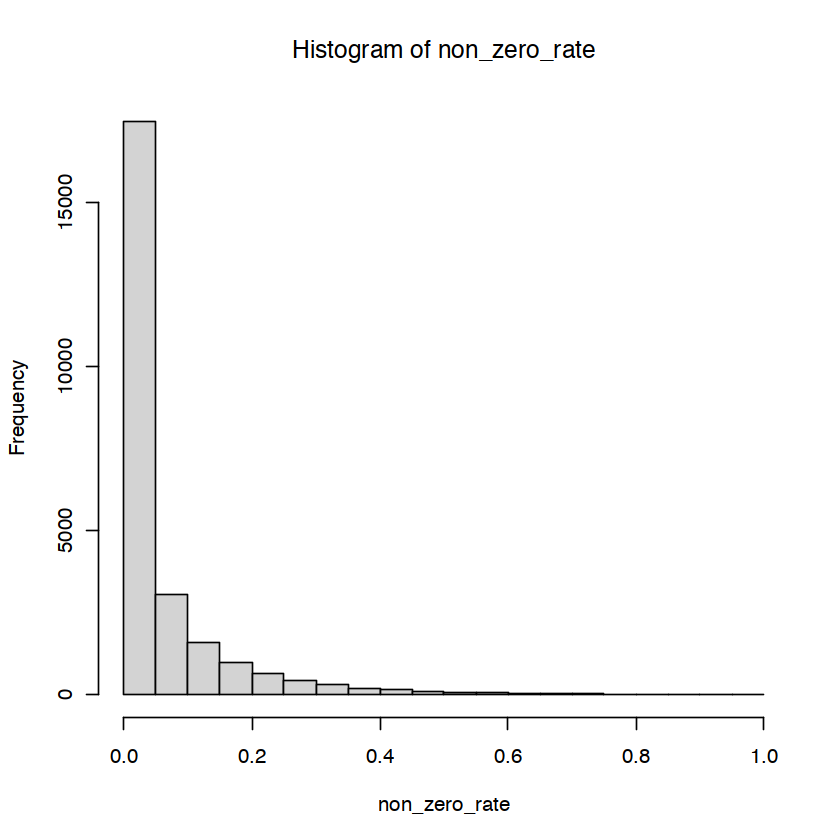

In [3]:
non_zero_rate <- apply(gene_count, 1, function(x) sum(x != 0) / length(x))
hist(non_zero_rate)

In [4]:
df_gene  = df_gene[non_zero_rate > 0.05 ,]

In [5]:
Seu_Obj <- CreateSeuratObject(counts = gene_count[non_zero_rate > 0.05 ,], project = "A549")

In [6]:
dim(Seu_Obj)

[1] 7699 5952

In [7]:
table(df_gene['gene_id'] == rownames(Seu_Obj))


TRUE 
7699 

In [8]:
print(table(Cells(Seu_Obj) == df_cell$sample))
Seu_Obj$treatment_time = df_cell$cell_type


TRUE 
5952 


## log-norm

Normalizing layer: counts

Finding variable features for layer counts

Regressing out nCount_RNA

Centering and scaling data matrix

PC_ 1 
Positive:  ENSG00000018236.10, ENSG00000184384.9, ENSG00000099139.9, ENSG00000151491.8, ENSG00000067715.9, ENSG00000129595.8, ENSG00000005108.11, ENSG00000109452.8, ENSG00000073282.8, ENSG00000115414.14 
	   ENSG00000128512.15, ENSG00000184588.13, ENSG00000172159.11, ENSG00000153250.13, ENSG00000139132.10, ENSG00000106258.9, ENSG00000144642.16, ENSG00000171889.3, ENSG00000147642.12, ENSG00000118922.12 
	   ENSG00000206530.4, ENSG00000249395.2, ENSG00000260658.1, ENSG00000182836.5, ENSG00000197565.11, ENSG00000072858.6, ENSG00000256248.1, ENSG00000168675.14, ENSG00000182752.8, ENSG00000114861.14 
Negative:  ENSG00000205426.6, ENSG00000184009.5, ENSG00000103257.4, ENSG00000074800.9, ENSG00000123416.11, ENSG00000120885.15, ENSG00000075624.9, ENSG00000161016.11, ENSG00000196924.10, ENSG00000167658.11 
	   ENSG00000108518.7, ENSG00000204628.7, ENSG00000

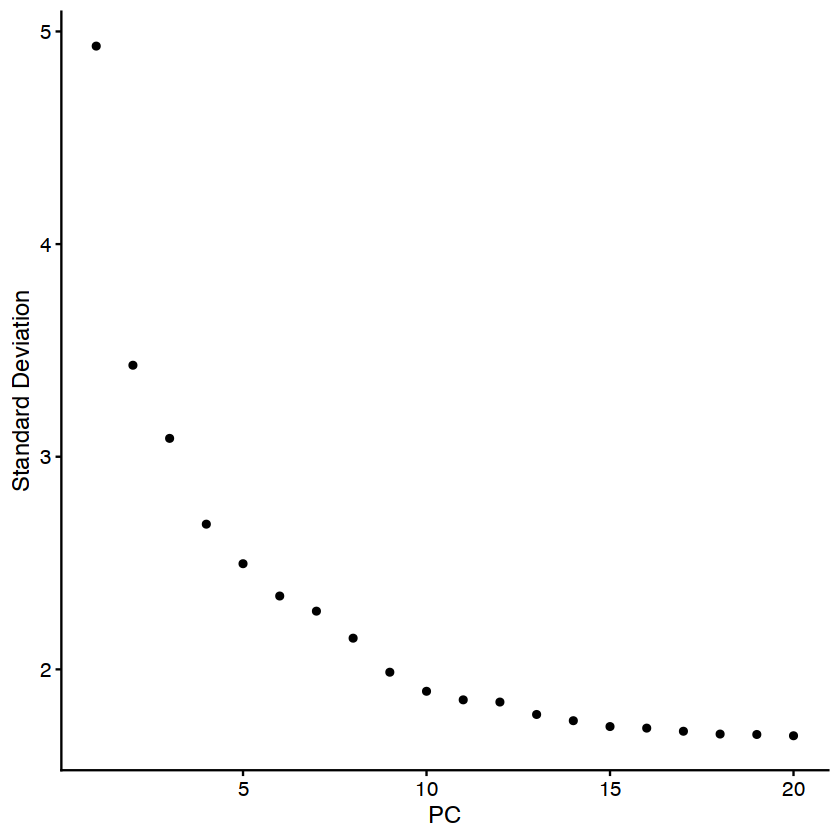

In [9]:
Seu_Obj <- NormalizeData(Seu_Obj, normalization.method = "LogNormalize", scale.factor = 10000)
Seu_Obj <- FindVariableFeatures(Seu_Obj, selection.method = "vst", nfeatures = 3000)
Seu_Obj <- ScaleData(Seu_Obj,vars.to.regress = 'nCount_RNA') # 
Seu_Obj <- RunPCA(Seu_Obj, features = VariableFeatures(object = Seu_Obj))
ElbowPlot(Seu_Obj)

Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
12:28:20 UMAP embedding parameters a = 0.9922 b = 1.112

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by 'BiocGenerics'

12:28:20 Read 5952 rows and found 10 numeric columns

12:28:20 Using Annoy for neighbor search, n_neighbors = 30

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by 'BiocGenerics'

12:28:20 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

12:28:21 Writing NN index file to t

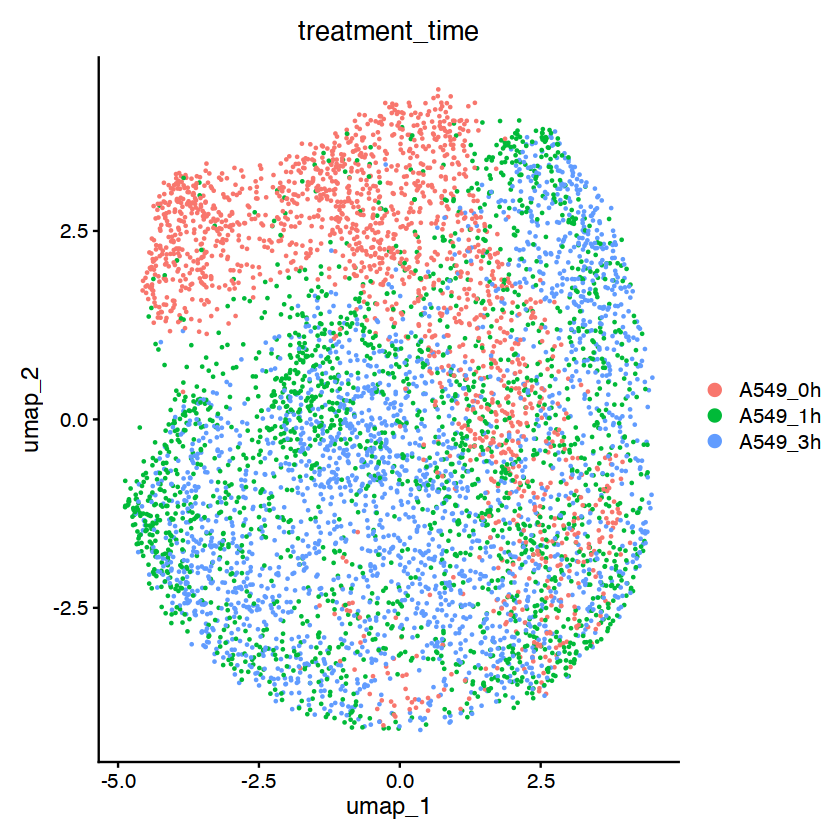

In [10]:
Seu_Obj <- RunUMAP(Seu_Obj, dims = 1:10)
DimPlot(Seu_Obj, reduction = "umap",group.by = 'treatment_time')

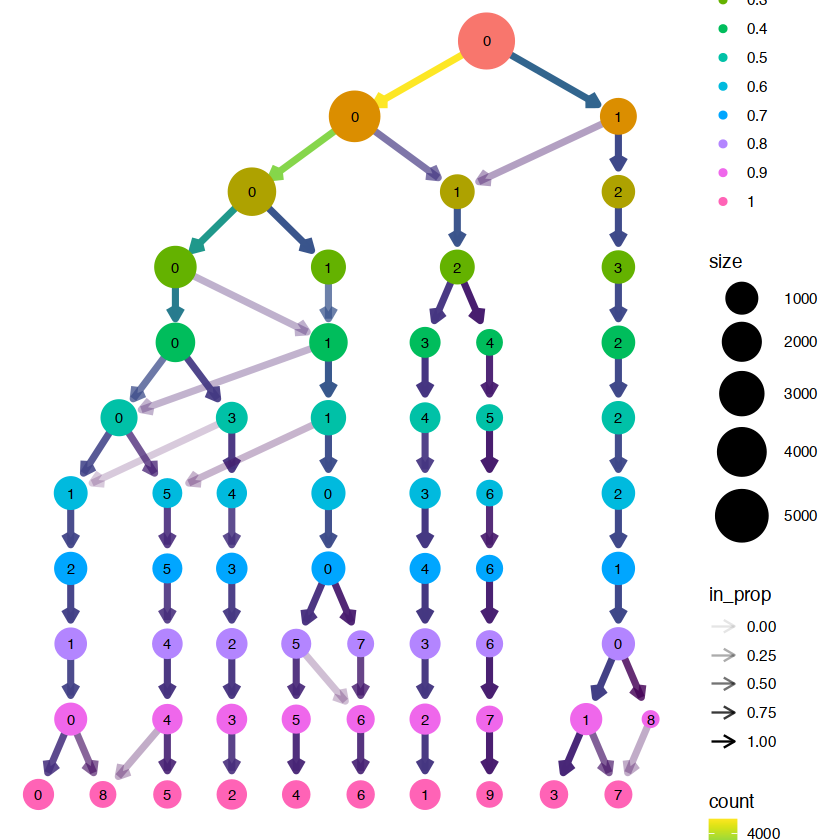

In [11]:
cluster_resolution <- seq(0,1,0.1)
n_pc = 10

Seu_Obj <- Seurat::FindNeighbors(Seu_Obj, reduction = "pca",  dims = 1:n_pc, verbose = FALSE)

for (resolution in cluster_resolution) {
    Seu_Obj <- Seurat::FindClusters(Seu_Obj, resolution = resolution, verbose = FALSE)
    }

clustree::clustree(Seu_Obj, prefix = "RNA_snn_res.")

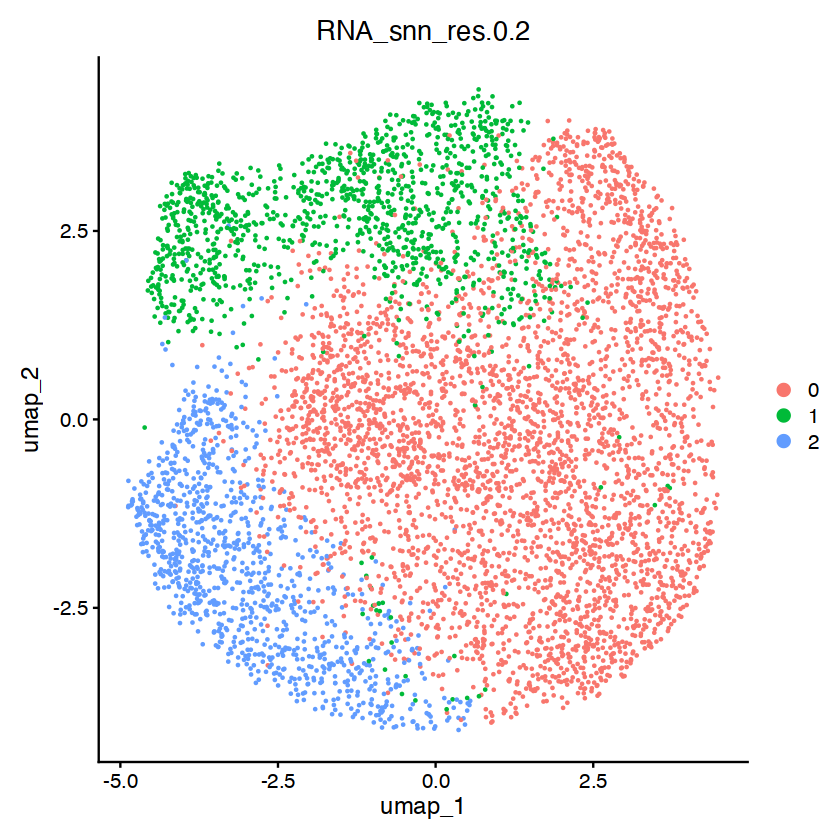

In [12]:
DimPlot(Seu_Obj, reduction = "umap",group.by = 'RNA_snn_res.0.2')

In [13]:
aricode::ARI(Seu_Obj$treatment_time,Seu_Obj$RNA_snn_res.0.2)

[1] 0.2018095

In [14]:
saveRDS(Seu_Obj,'V6/Seu_Obj_0.rds')

In [15]:
raw_count_matrx = Seu_Obj@assays$RNA$counts
write10xCounts(path = './RNA_data', x = raw_count_matrx,
barcodes = colnames(raw_count_matrx), gene.id = rownames(raw_count_matrx),
gene.symbol = df_gene$gene_short_name
)

In [24]:
p<-DimPlot(Seu_Obj, reduction = "umap",group.by = 'RNA_snn_res.0.2') + labs(title = '')
cowplot::save_plot('./RNA_UAMP_cluster.png', p,
                   base_aspect_ratio = 1, base_height = 4)

Seu_Obj$treatment <- substring(Seu_Obj$treatment_time,6)

p<-DimPlot(Seu_Obj, reduction = "umap",group.by = 'treatment') + labs(title = 'Treatment')
cowplot::save_plot('./RNA_UAMP_treatment_time.png', p,
                   base_aspect_ratio = 1, base_height = 4)


In [ ]:
write.csv(Seu_Obj@meta.data,'./RNA_data/df_cell.csv')

# SCVI

In [1]:
import os
import tempfile

import scanpy as sc
import scvi
import torch
import pandas as pd

/Users/mij51/opt/anaconda3/envs/scvi-env-39/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/Users/mij51/opt/anaconda3/envs/scvi-env-39/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/Users/mij51/opt/anaconda3/envs/scvi-env-39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/mij51/opt/anaconda3/envs/scvi-env-39/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be r

In [2]:
scvi.settings.seed = 0

Global seed set to 0


In [3]:
adata = sc.read_10x_mtx('./RNA_data/')
df = pd.read_csv('./RNA_data/df_cell.csv',index_col = 0)
adata.obs['treament'] = df.cell_type
adata

In [7]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=100)
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)

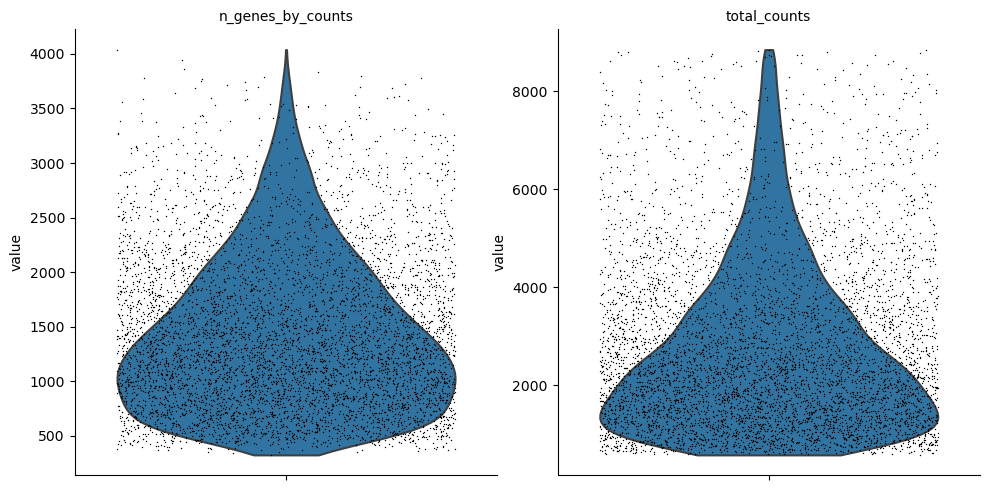

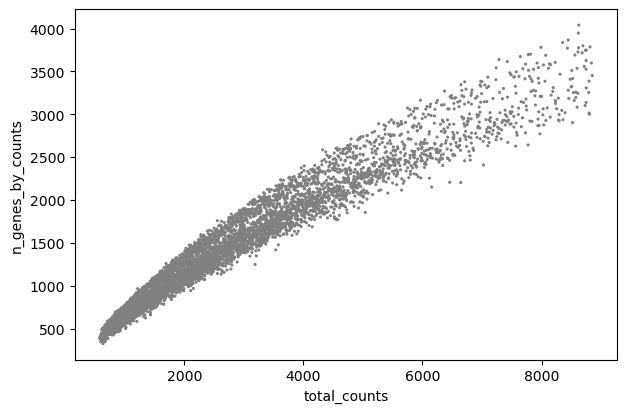

In [9]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts'],
             jitter=0.4, multi_panel=True)

sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [10]:
adata.layers["counts"] = adata.X.copy()  # preserve counts
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata  # freeze the state in `.raw`

In [11]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=3000,
    subset=True,
    layer="counts",
    flavor="seurat_v3"
    )

In [12]:
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",
    categorical_covariate_keys=["treament"])

/Users/mij51/opt/anaconda3/envs/scvi-env-39/lib/python3.9/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)
/Users/mij51/opt/anaconda3/envs/scvi-env-39/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:101: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)


In [13]:
model = scvi.model.SCVI(adata, n_layers=1, n_latent=10, gene_likelihood="nb")

In [16]:
model

SCVI Model with the following params: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: nb, 
latent_distribution: normal
Training status: Trained
Model's adata is minified?: False

In [ ]:
model.train()

In [14]:
model_dir = os.path.join('./Run1/', "scvi_model")
# model.save(model_dir, overwrite=True)
model = scvi.model.SCVI.load(model_dir, adata=adata)

INFO     File ./V6/Run1/scvi_model/model.pt already downloaded                                                     


/Users/mij51/opt/anaconda3/envs/scvi-env-39/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:101: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)


In [15]:
SCVI_LATENT_KEY = "X_scVI"

latent = model.get_latent_representation()
adata.obsm[SCVI_LATENT_KEY] = latent
latent.shape

/Users/mij51/opt/anaconda3/envs/scvi-env-39/lib/python3.9/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)


(5952, 10)

In [ ]:
# use scVI latent space for UMAP generation
sc.pp.neighbors(adata, use_rep=SCVI_LATENT_KEY)
sc.tl.umap(adata, min_dist=0.1)

In [ ]:
sc.pl.umap(
    adata,
    color=["treament"],
    frameon=False,
)

In [ ]:
denoised = model.get_normalized_expression(adata, library_size=1e4)
denoised.shape

In [ ]:
denoised.to_csv('./denoised_mat.csv')

# SCVI imputed 

In [2]:
library(Seurat)
library(LaGrACE)
library(clustree)

In [3]:
load('./sci-CAR_analysis-master/Data/A549_RNAseq_cell_gene_gene_count.RData')

In [4]:
input_matrix = read.csv('./denoised_mat.csv',row.names=1)

In [5]:
Seu_Obj <- CreateSeuratObject(counts = t(input_matrix), project = "A549")
Seu_Obj

Warning message:
"Data is of class matrix. Coercing to dgCMatrix."


An object of class Seurat 
3000 features across 5952 samples within 1 assay 
Active assay: RNA (3000 features, 0 variable features)
 1 layer present: counts

In [6]:
print(table(Cells(Seu_Obj) == df_cell$sample))
Seu_Obj$treatment_time = df_cell$cell_type


TRUE 
5952 


## log-norm

Normalizing layer: counts

Finding variable features for layer counts

Centering and scaling data matrix

PC_ 1 
Positive:  KRT81, ACTG1, TUBA1B, ENO1, SLC7A5, RPL8, SNRPB, ACTB, EEF2, GNB2L1 
	   CFL1, RPL18, PFN1, CLU, PRDX1, SLC1A5, SDC1, G6PD, RPS16, RPS2 
	   FLNA, TFPI2, TUFM, RPS4X, ID3, FAU, PHB2, TAGLN2, ARHGDIA, ATP5B 
Negative:  MAML2, EPS8, PCSK5, RP11.368L12.1, GPCPD1, EPB41L4A, TP63, ARHGAP18, PDE1A, DPYD 
	   FAM214A, PLCXD3, INPP4B, AC092594.1, SERINC5, TTLL6, PRICKLE2, SPATA6L, RASEF, PLCB1 
	   CACNA1D, NAMPT, CATSPERB, CYP3A5, ANKS1B, COL4A6, FHIT, FN1, RP3.323P13.2, FRMD3 
PC_ 2 
Positive:  SHC1, KRT19, ALDH3A1, LGALS3BP, TGM2, S100A6, KRT8, STRA6, CTSD, MCL1 
	   AC006262.5, CST3, TSC22D3, THBD, TRIM47, S100A4, SGK1, TP53I3, MUC5AC, TNS4 
	   AGR2, CPM, GPX2, RABAC1, CD63, SLC2A1, MMP28, LDOC1, TAPBP, TPPP3 
Negative:  LINC00473, LINC00669, CIT, KIF18B, BRIP1, CEP152, MKI67, KIF14, ASPM, CENPF 
	   TOP2A, CENPE, HJURP, SPC25, FOXM1, CENPJ, CKAP2L, DLGAP5, GALNT14, 

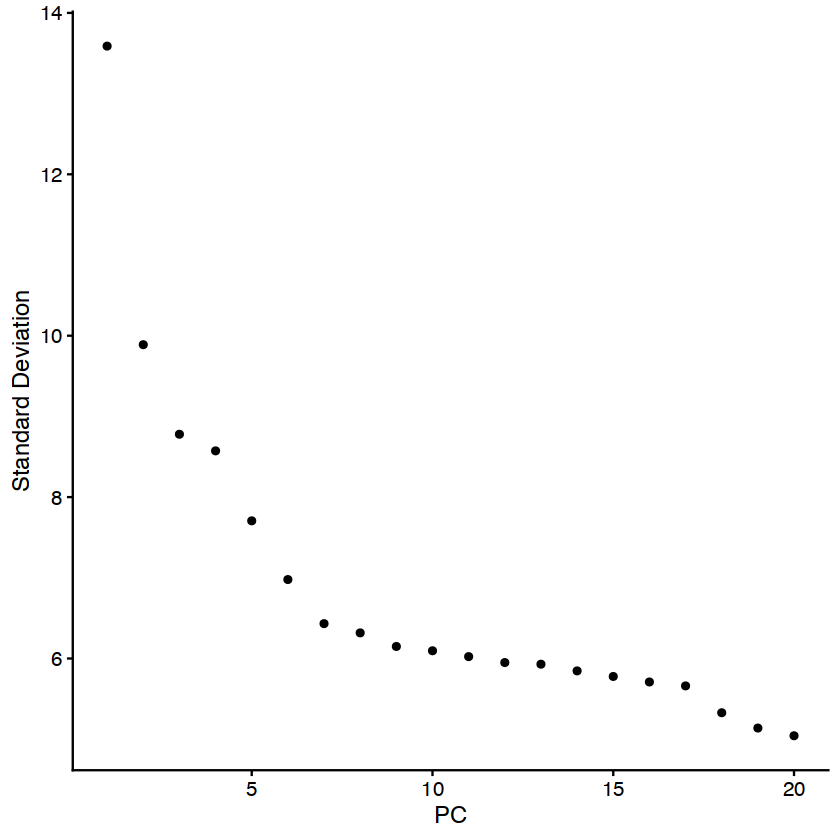

In [7]:
Seu_Obj <- NormalizeData(Seu_Obj, normalization.method = "LogNormalize", scale.factor = 10000)
Seu_Obj <- FindVariableFeatures(Seu_Obj, selection.method = "vst", nfeatures = 3000)
Seu_Obj <- ScaleData(Seu_Obj) # 
Seu_Obj <- RunPCA(Seu_Obj, features = VariableFeatures(object = Seu_Obj))
ElbowPlot(Seu_Obj)

Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
12:40:06 UMAP embedding parameters a = 0.9922 b = 1.112

12:40:06 Read 5952 rows and found 10 numeric columns

12:40:06 Using Annoy for neighbor search, n_neighbors = 30

12:40:06 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

12:40:07 Writing NN index file to temp file /var/folders/yq/wgt5tq6d7q7d6l08jg46y37ntzjz8q/T//RtmpD4a40Z/filed9887ae0a10a

12:40:07 Searching Annoy index using 1 thread, search_k = 3000

12:40:08 Annoy recall = 100%

12:40:09 Commencing smooth kNN distance calibrat

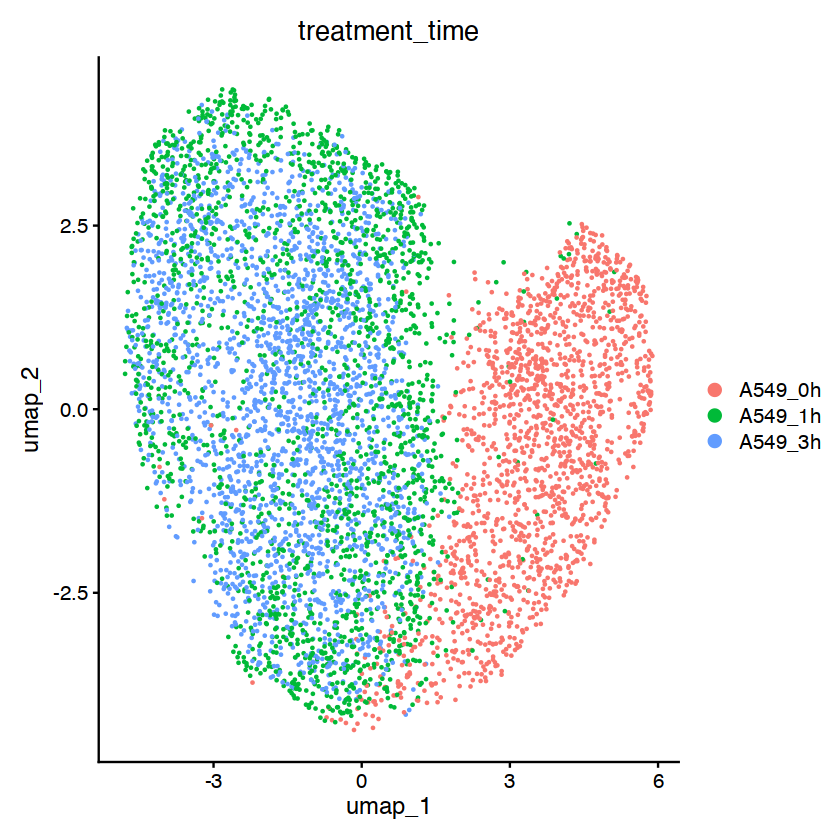

In [8]:
Seu_Obj <- RunUMAP(Seu_Obj, dims = 1:10)
DimPlot(Seu_Obj, reduction = "umap",group.by = 'treatment_time')

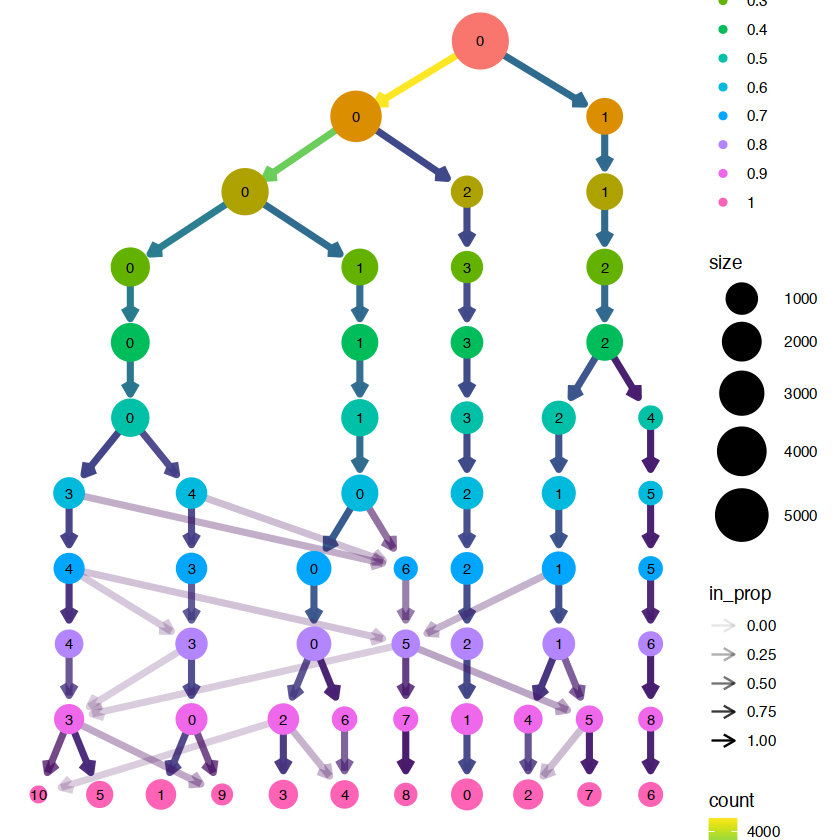

In [9]:
cluster_resolution <- seq(0,1,0.1)
n_pc = 10

Seu_Obj <- Seurat::FindNeighbors(Seu_Obj, reduction = "pca",  dims = 1:n_pc, verbose = FALSE)

for (resolution in cluster_resolution) {
  Seu_Obj <- Seurat::FindClusters(Seu_Obj, resolution = resolution, verbose = FALSE)
}

clustree::clustree(Seu_Obj, prefix = "RNA_snn_res.")

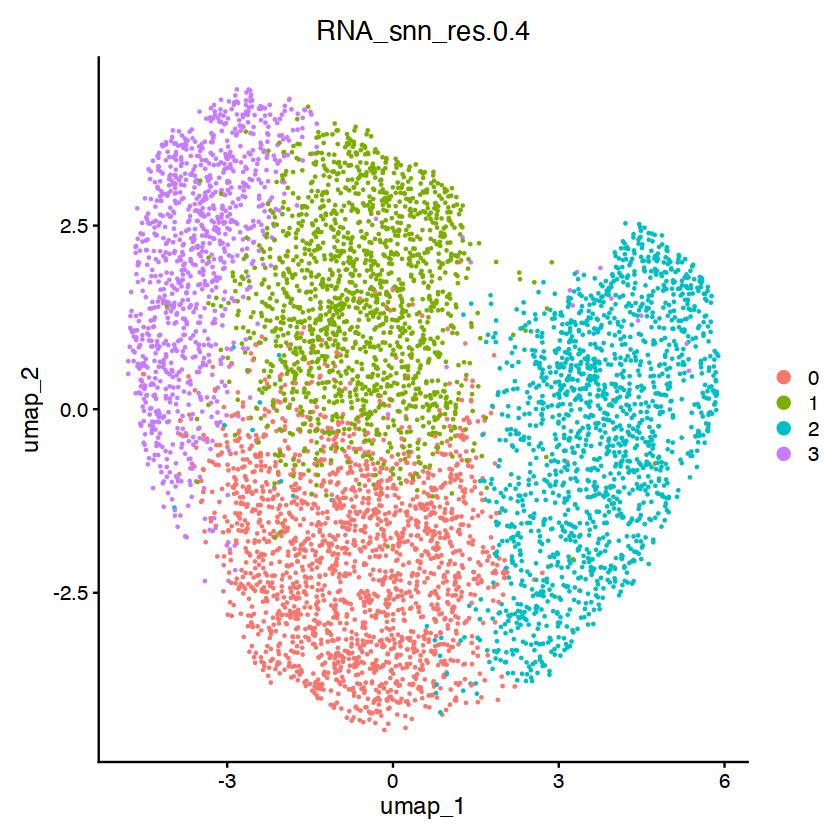

In [10]:
DimPlot(Seu_Obj, reduction = "umap",group.by = 'RNA_snn_res.0.4')

In [11]:
aricode::ARI(Seu_Obj$treatment_time,Seu_Obj$RNA_snn_res.0.3)

[1] 0.3053187

In [12]:
saveRDS(Seu_Obj,'./Seurat_scvi.rds')

In [15]:
p<-DimPlot(Seu_Obj, reduction = "umap",group.by = 'RNA_snn_res.0.4') + labs(title = '')
cowplot::save_plot('./SCVI_UAMP_cluster.png', p,
                   base_aspect_ratio = 1, base_height = 4)

Seu_Obj$treatment <- substring(Seu_Obj$treatment_time,6)

p<-DimPlot(Seu_Obj, reduction = "umap",group.by = 'treatment') + labs(title = 'Treatment')
cowplot::save_plot('./SCVI_UAMP_treatment_time.png', p,
                   base_aspect_ratio = 1, base_height = 4)

# LOVE

In [2]:
library(LaGrACE)
library(MASS)
library(reshape2)

Loading required package: clustree

Loading required package: ggraph

Loading required package: ggplot2



In [17]:
non_zero_rate <- apply(Seu_Obj@assays$RNA$counts, 1, function(x) sum(x > 0.2) ) # / length(x)
table(non_zero_rate> 500)


TRUE 
3000 

In [19]:
Y<-t(as.matrix(  Seu_Obj@assays$RNA$data   ))
reference_index<- Seu_Obj$treatment_time %in% c('A549_0h') #determine reference sample index
Y_ref<-Y[reference_index,] 
Y_mean<-apply(Y_ref, 2, function(x) mean(x))
Y_sd<-apply(Y_ref, 2, function(x) sd(x))

In [20]:
# perform z score normalization based on reference group
Y_zscore<-sweep(Y, MARGIN = 2, STATS = Y_mean, `-`)
Y_zscore<-sweep(Y_zscore, MARGIN = 2, STATS = Y_sd, `/`)

In [21]:
table(reference_index)

reference_index
FALSE  TRUE 
 4306  1646 

In [21]:
# delta_seq<-seq(0.1,0.8,by=0.1) # scan over possible cluster anchor tuning hyperparameter, delta 
delta_seq<-seq(0.1,3,by=0.1) # scan over possible cluster anchor tuning hyperparameter, delta 
Y_LOVE_result<-LOVE_Delta_Tuning(Y_zscore[reference_index,], delta_seq) # perform LOVE on reference group

[1] "lbd 1 optDelta 0.0069743356850799"
[1] "BIC: "            "31860.544909885"  " AIC: "           "30087.3430008393"
[1] "lbd 1 optDelta 0.0139486713701598"
[1] "BIC: "            "31474.8307647448" " AIC: "           "29842.1875436112"
[1] "lbd 1 optDelta 0.0209230070552397"
[1] "BIC: "            "31203.944498402"  " AIC: "           "29782.1393091367"
[1] "lbd 1 optDelta 0.0278973427403196"
[1] "BIC: "            "30930.2100485536" " AIC: "           "29865.2076824499"
[1] "lbd 1 optDelta 0.0348716784253995"
[1] "BIC: "            "30805.0900259633" " AIC: "           "30021.2050356839"
[1] "lbd 1 optDelta 0.0418460141104794"
[1] "BIC: "            "30756.4444192147" " AIC: "           "30226.6462878535"
[1] "lbd 1 optDelta 0.0488203497955593"
[1] "BIC: "            "30682.2428536741" " AIC: "           "30320.0339271312"
[1] "lbd 1 optDelta 0.0557946854806392"
[1] "BIC: "            "30440.6293532008" " AIC: "           "30213.5730111888"
[1] "lbd 1 optDelta 0.0627690211657191"


In [26]:
saveRDS(Y_LOVE_result,'./Y_LOVE_result.rds')

In [112]:
Y_LOVE_opt<-Y_LOVE_result$LOVE_result[[which.min(Y_LOVE_result$AIC)]] # pick up optimum delta value based on AIC score
saveRDS(Y_LOVE_opt,'./LOVE/Y_LOVE_opt.rds')

In [114]:
metadata<-Seu_Obj@meta.data
table(metadata$treatment_time)
saveRDS(metadata,'metadata.rds')


A549_0h A549_1h A549_3h 
   1646    2037    2269 

## LaGrACE

In [22]:
Y_LOVE_opt<-readRDS('./LOVE/Y_LOVE_opt.rds')
A_M<-Y_LOVE_opt$A
Love_features<-ginv(t(A_M)  %*% A_M) %*% t(A_M)%*%t(as.matrix(Y_zscore)) # infer latent factors for all samples

rownames(Love_features)<-paste0('LOVE_',1:nrow(Love_features))
input_feature<-t(Love_features)

In [24]:
reference_index<- Seu_Obj$treatment_time %in% c('A549_0h') #determine reference sample index
dir.create(path=paste0("./PD_selection"),showWarnings=FALSE)

In [30]:
input_feature<-as.data.frame(input_feature)
names(input_feature)<-make.names(colnames(input_feature),unique = TRUE)
rownames(input_feature)<-make.names(rownames(input_feature),unique = TRUE)

In [ ]:
PD_Deviation<-Calculate_LaGrACE_deviation(input_data=input_feature[reference_index,],
                                        pd_value=seq(from = 1, to = 10, by=0.5), # scan over graph sparsity penality hyperparameter
                                        maxCat=5,out_dir=paste0("./PD_selection"))


In [ ]:
saveRDS(PD_Deviation,'./ref_PD_Deviation_imputed_RNA.rds')

[1] 1
Levels: 1 1.5 2 2.5 3 3.5 4 4.5 5 5.5 6 6.5 7 7.5 8 8.5 9 9.5 10

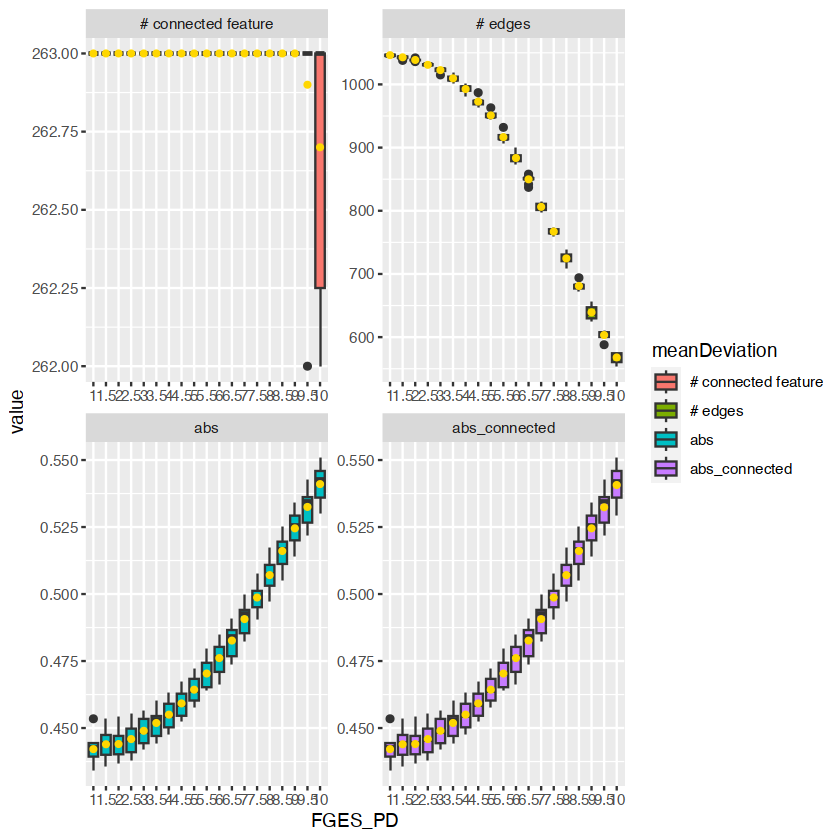

In [25]:
PD_Deviation<-readRDS('./ref_PD_Deviation_imputed_RNA.rds')
PD_plot<-as.data.frame(t(PD_Deviation[c(9,1,5,2,3),]))
colnames(PD_plot)[1]<-c('FGES_PD')
PD_plot$FGES_PD<-as.factor(PD_plot$FGES_PD)
S<-aggregate(PD_plot[, 2:5], list(PD_plot$FGES_PD), mean)
# PD value with smallest prediction error 
opt_PD<-S$Group.1[which.min(S$abs)]
opt_PD

PD_plot <- melt(PD_plot ,  id.vars = 'FGES_PD', variable.name = 'meanDeviation')
p<- ggplot(PD_plot, aes(x=FGES_PD,y=value)) + geom_boxplot(aes(fill=meanDeviation)) + stat_summary(fun=mean, geom="point", shape=20, size=2, color="gold1", fill="gold1")+ facet_wrap( ~ meanDeviation, scales="free",ncol=2)
p
cowplot::save_plot('./optimal_PD.png', p,
                   base_aspect_ratio = 1.5, base_height = 10)

In [31]:
# Infer network deviation for all samples
LaGrACE_deviation_opt_PD<-run_LaGrACE(input_feature, reference_samples = reference_index, fges_pd = opt_PD, out_dir="./Testing") 
saveRDS(LaGrACE_deviation_opt_PD,'./LaGrACE_deviation_opt.rds')

# Clustering

In [4]:
metadata<-readRDS('metadata.rds')
reference_index<- metadata$treatment_time %in% c('A549_0h') #determine reference sample index
table(reference_index)

reference_index
FALSE  TRUE 
 4306  1646 

In [5]:
LaGrACE_deviation_opt_PD<-readRDS('./LaGrACE_deviation_opt.rds')
LaGrACE_feature<-LaGrACE_deviation_opt_PD$features

In [6]:
seurat_obj <- Seurat::CreateSeuratObject(counts = t(LaGrACE_feature))
seurat_obj@meta.data <- cbind(seurat_obj@meta.data, metadata[,4,drop=FALSE])
seurat_obj@assays$RNA$data = seurat_obj@assays$RNA$counts
seurat_obj@assays$RNA$scale.data = as.matrix(seurat_obj@assays$RNA$counts)

Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
Warning message:
"Data is of class matrix. Coercing to dgCMatrix."


In [7]:
seurat_obj <- Seurat::RunPCA(object = seurat_obj, features = rownames(seurat_obj), seed.use = 1, verbose=FALSE)

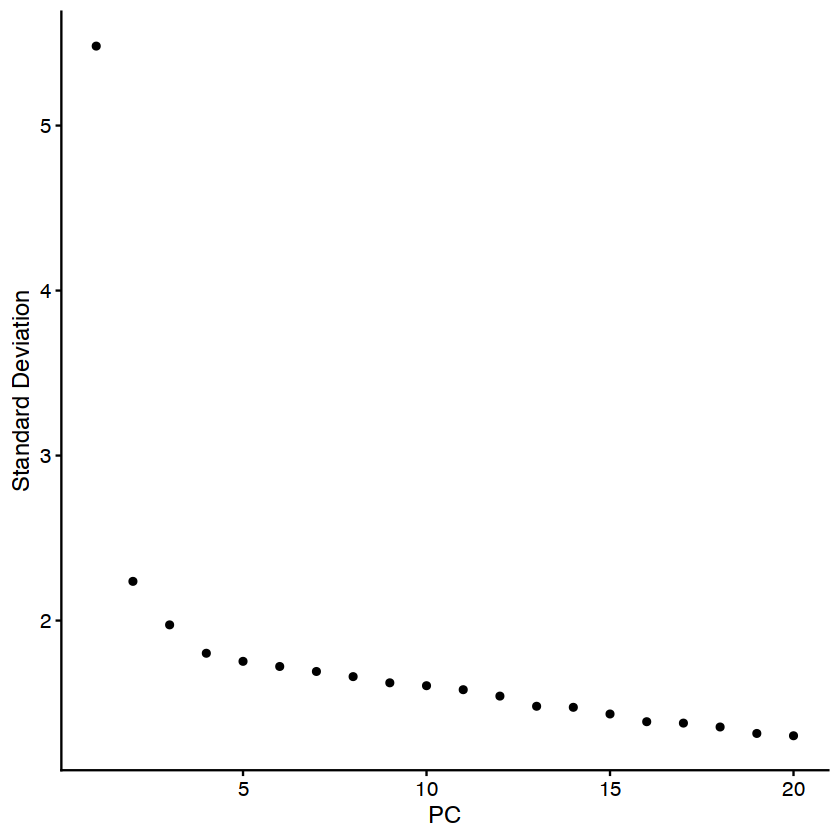

In [8]:
ElbowPlot(seurat_obj)

Warning message in Seurat::JackStraw(seurat_obj, num.replicate = 10, dims = 30):
"Number of variable genes given 0.01 as the prop.freq is low. Consider including more variable genes and/or increasing prop.freq. Continuing with 3 genes in every random sampling."
Warning message:
"Removed 5544 rows containing missing values (`geom_point()`)."


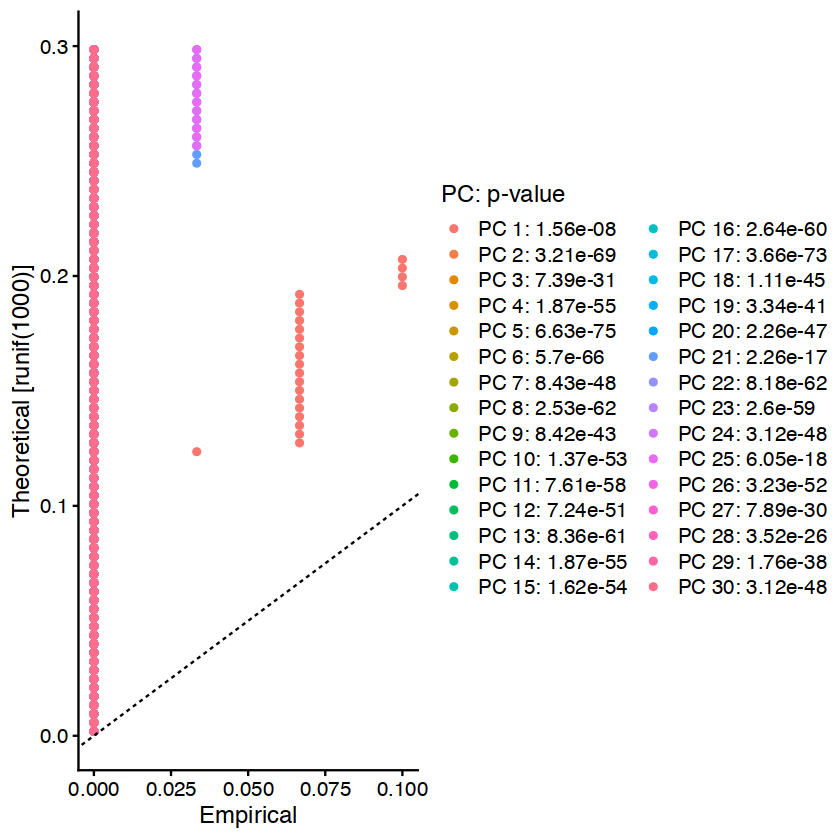

In [9]:
# perform JackStaw procedure and identify 'significant' PCs as those who have a strong enrichment of low p-value features. (https://satijalab.org/seurat/articles/pbmc3k_tutorial.html)
seurat_obj <- Seurat::JackStraw(seurat_obj, num.replicate = 10,dims = 30)
seurat_obj <- Seurat::ScoreJackStraw(seurat_obj, dims = 1:30)
Seurat::JackStrawPlot(seurat_obj, dims = 1:30)

In [10]:
pct <- seurat_obj[["pca"]]@stdev / sum(seurat_obj[["pca"]]@stdev) * 100
# Calculate cumulative percents for each PC
cumu <- cumsum(pct)

# Determine which PC exhibits cumulative percent greater than 90% and % variation associated with the PC as less than 5
co1 <- which(cumu > 90 & pct < 5)[1]
# Determine the difference between variation of PC and subsequent PC
co2 <- sort(which((pct[1:length(pct) - 1] - pct[2:length(pct)]) > 0.05), decreasing = T)[1] -1
pcs <- min(co1, co2)
pcs

[1] 17

Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
10:51:53 UMAP embedding parameters a = 0.9922 b = 1.112

10:51:53 Read 5952 rows and found 17 numeric columns

10:51:53 Using Annoy for neighbor search, n_neighbors = 30

10:51:53 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

10:51:54 Writing NN index file to temp file /var/folders/yq/wgt5tq6d7q7d6l08jg46y37ntzjz8q/T//Rtmpa5K9mO/file13fd9452463d

10:51:54 Searching Annoy index using 1 thread, search_k = 3000

10:51:56 Annoy recall = 100%

10:51:56 Commencing smooth kNN distance calibrat

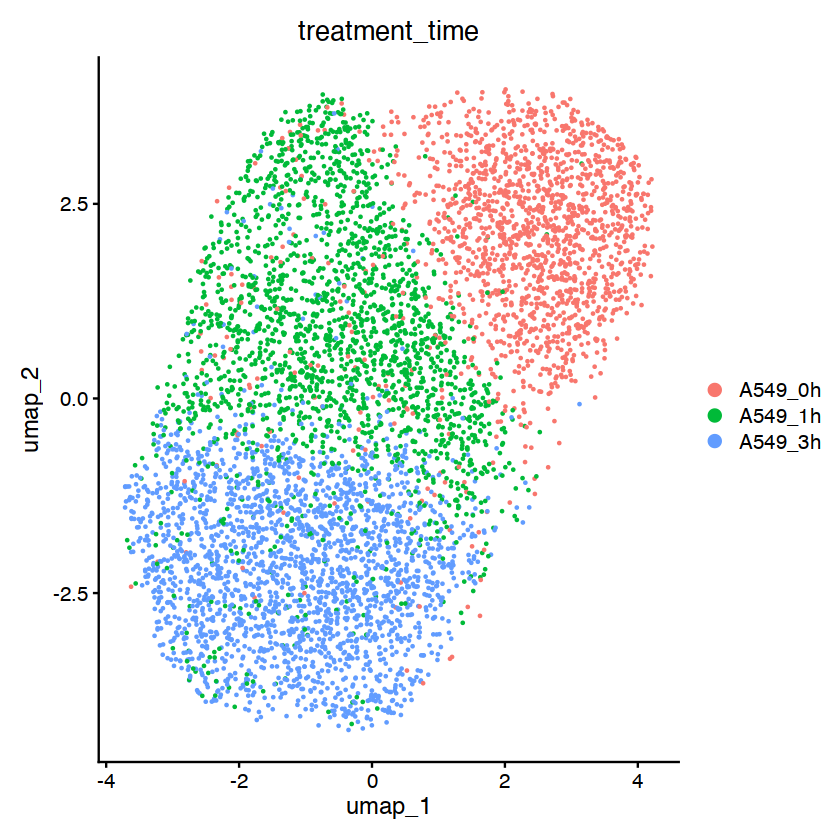

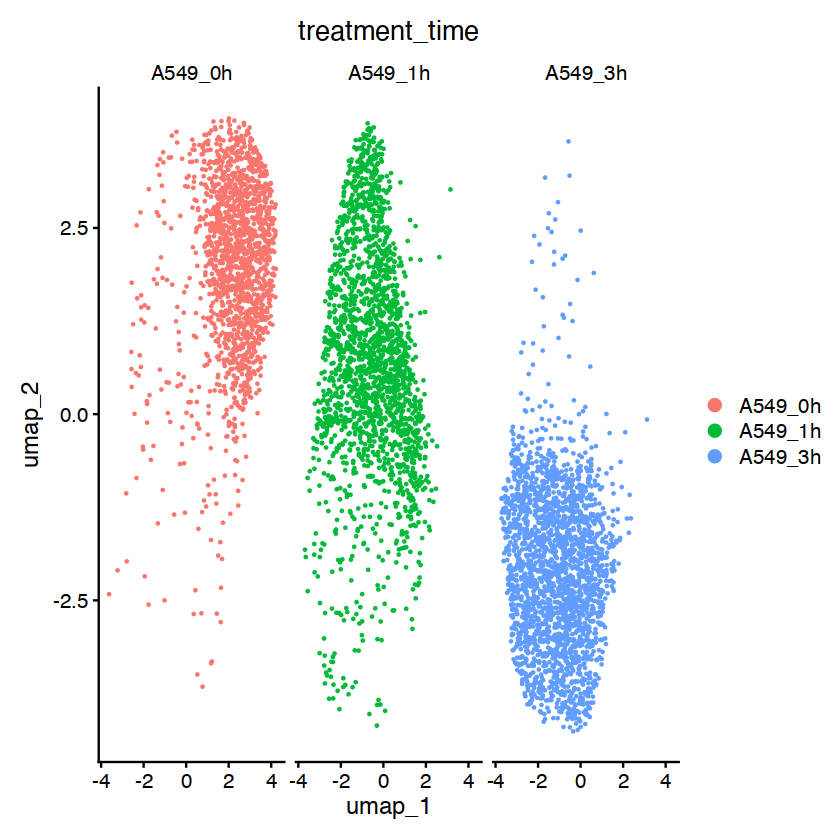

In [11]:
seurat_obj <- RunUMAP(seurat_obj, dims = 1:17)
DimPlot(seurat_obj, reduction = "umap",group.by = 'treatment_time')
DimPlot(seurat_obj, reduction = "umap",group.by = 'treatment_time',split.by = 'treatment_time')

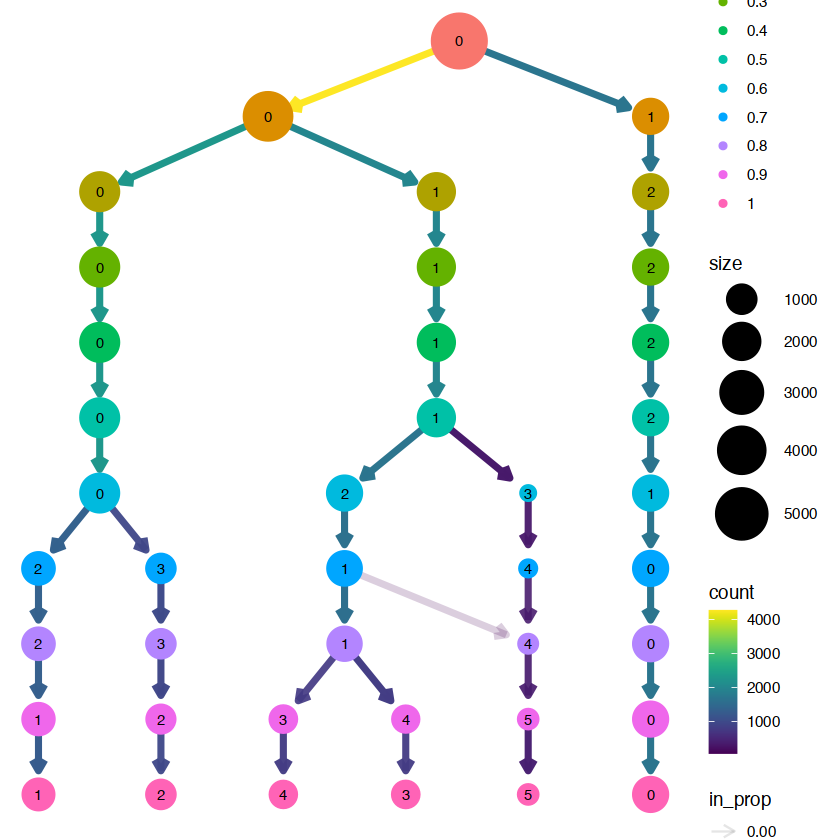

In [13]:
cluster_resolution <- seq(0,1,0.1)
n_pc = 17

seurat_obj <- Seurat::FindNeighbors(seurat_obj, reduction = "pca",  dims = 1:n_pc, verbose = FALSE)

for (resolution in cluster_resolution) {
  seurat_obj <- Seurat::FindClusters(seurat_obj, resolution = resolution, verbose = FALSE)
}

clustree::clustree(seurat_obj, prefix = "RNA_snn_res.")

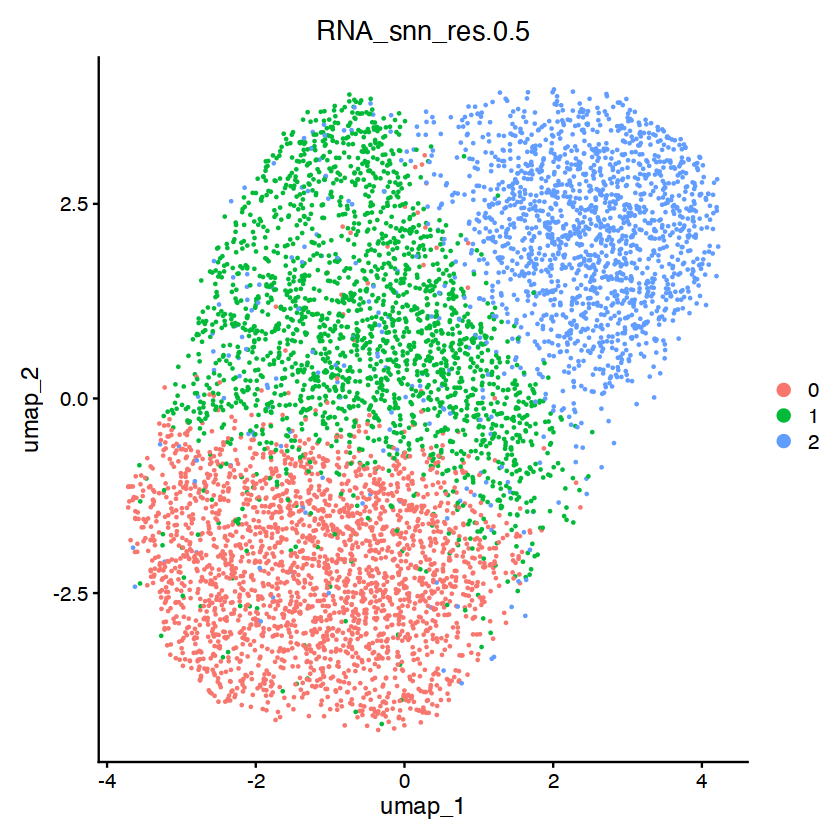

In [16]:
DimPlot(seurat_obj, reduction = "umap",group.by = 'RNA_snn_res.0.5')

In [19]:
table(seurat_obj$treatment_time,seurat_obj$RNA_snn_res.0.5)

         
             0    1    2
  A549_0h    0    5 1641
  A549_1h  151 1851   35
  A549_3h 2127  138    4

In [22]:
aricode::ARI(seurat_obj$treatment_time,seurat_obj$RNA_snn_res.0.5)

[1] 0.8347078

In [18]:
saveRDS(seurat_obj,'./Seurat_lagrace.rds')

In [23]:
p<-DimPlot(seurat_obj, reduction = "umap",group.by = 'RNA_snn_res.0.5') + labs(title = '')
cowplot::save_plot('./Lagrace_UAMP_cluster.png', p,
                   base_aspect_ratio = 1, base_height = 4)

seurat_obj$treatment <- substring(seurat_obj$treatment_time,6)

p<-DimPlot(seurat_obj, reduction = "umap",group.by = 'treatment') + labs(title = 'Treatment')
cowplot::save_plot('./Lagrace_UAMP_treatment_time.png', p,
                   base_aspect_ratio = 1, base_height = 4)

p<-DimPlot(seurat_obj, reduction = "umap",group.by = 'treatment',split.by = 'treatment') + labs(title = 'Treatment')
cowplot::save_plot('./Lagrace_UAMP_treatment_time_splited.png', p,
                   base_aspect_ratio = 1.5, base_height = 4)

# Latent Factor Discovery

In [139]:
library(Seurat)
library(LaGrACE)
library(MASS)
library(reshape2)
seurat_obj<- readRDS('./Seurat_lagrace.rds')

In [9]:
Seu_Obj <- readRDS('./Seurat_scvi.rds')

Y<-t(as.matrix(  Seu_Obj@assays$RNA$data   ))
reference_index<- Seu_Obj$treatment_time %in% c('A549_0h') #determine reference sample index
Y_ref<-Y[reference_index,] 
Y_mean<-apply(Y_ref, 2, function(x) mean(x))
Y_sd<-apply(Y_ref, 2, function(x) sd(x))


# perform z score normalization based on reference group
Y_zscore<-sweep(Y, MARGIN = 2, STATS = Y_mean, `-`)
Y_zscore<-sweep(Y_zscore, MARGIN = 2, STATS = Y_sd, `/`)

In [12]:
Y_LOVE_opt<-readRDS('./LOVE/Y_LOVE_opt.rds')
A_M<-Y_LOVE_opt$A
Love_features<-ginv(t(A_M)  %*% A_M) %*% t(A_M)%*%t(as.matrix(Y_zscore)) # infer latent factors for all samples

rownames(Love_features)<-paste0('LOVE_',1:nrow(Love_features))
input_feature<-t(Love_features)

In [25]:
colnames(Love_features) <- Cells(seurat_obj)
seurat_obj[['LOVE']] <- Love_features  %>% Seurat::CreateAssayObject()

Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"


In [47]:
Lagrace_mat <- t(as.matrix(seurat_obj@assays$RNA$counts))
correlation_results = cor(seurat_obj$treatments, Lagrace_mat, method = "spearman")
correlation_results_LaGrace = as.data.frame(correlation_results[,order(abs(correlation_results[1,]),decreasing = T)] )
head(correlation_results_LaGrace)
tail(correlation_results_LaGrace)
write.csv(correlation_results_LaGrace,'./Cor_spearman_loagrace_treatment_time.csv')

correlation_results[, order(abs(correlation_results[1, ]), decreasing = T)]
LOVE-53   0.7584266                                                                 
LOVE-101 -0.7563295                                                                 
LOVE-252 -0.6795610                                                                 
LOVE-78   0.6739960                                                                 
LOVE-123  0.6661615                                                                 
LOVE-216 -0.6532317

correlation_results[, order(abs(correlation_results[1, ]), decreasing = T)]
LOVE-242 -0.011178438                                                               
LOVE-38  -0.008019933                                                               
LOVE-146 -0.006985639                                                               
LOVE-181 -0.002165397                                                               
LOVE-144  0.001668536                                                               
LOVE-44  -0.001451274

In [48]:
LOVE_mat <- t(as.matrix(seurat_obj@assays$LOVE$counts))
correlation_results = cor(seurat_obj$treatments, LOVE_mat, method = "spearman")
correlation_results_LOVE = as.data.frame(correlation_results[,order(abs(correlation_results[1,]),decreasing = T)] )
head(correlation_results_LOVE)
tail(correlation_results_LOVE)
write.csv(correlation_results_LOVE,'./Cor_spearman_LOVE_treatment_time.csv')

correlation_results[, order(abs(correlation_results[1, ]), decreasing = T)]
LOVE-53   0.7288040                                                                 
LOVE-78   0.7167617                                                                 
LOVE-101 -0.4725587                                                                 
LOVE-102  0.4018921                                                                 
LOVE-48  -0.3878309                                                                 
LOVE-160  0.3875904

correlation_results[, order(abs(correlation_results[1, ]), decreasing = T)]
LOVE-185 -0.0017985066                                                              
LOVE-140  0.0016288986                                                              
LOVE-168  0.0014975342                                                              
LOVE-88  -0.0011481509                                                              
LOVE-137 -0.0010329856                                                              
LOVE-128 -0.0008441457

In [122]:
correlation_results_LOVE = cor(seurat_obj$treatments, LOVE_mat, method = "spearman")
correlation_results_LaGrace= cor(seurat_obj$treatments, Lagrace_mat, method = "spearman")

Cor_df <- c()
Cor_df$Cor_LaGrace = correlation_results_LaGrace[1,] 
Cor_df$Cor_LOVE = correlation_results_LOVE[1,] 


Cor_df <- as.data.frame(Cor_df)
Cor_df$Feature <- rownames(Cor_df) 
Cor_df$above_line <- abs(Cor_df$Cor_LaGrace) > abs(Cor_df$Cor_LOVE)

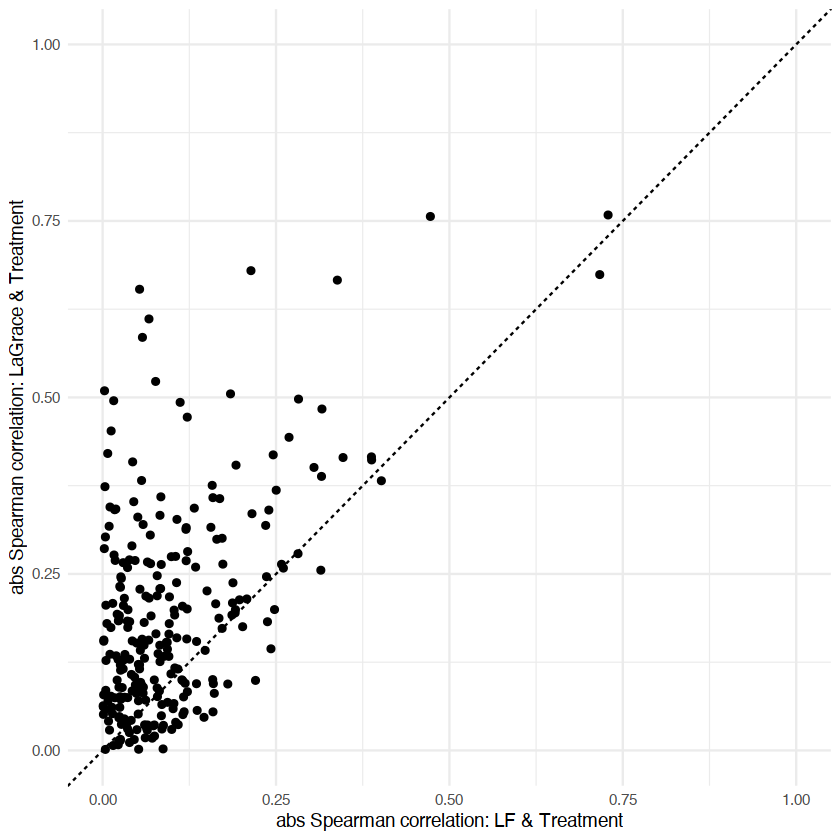

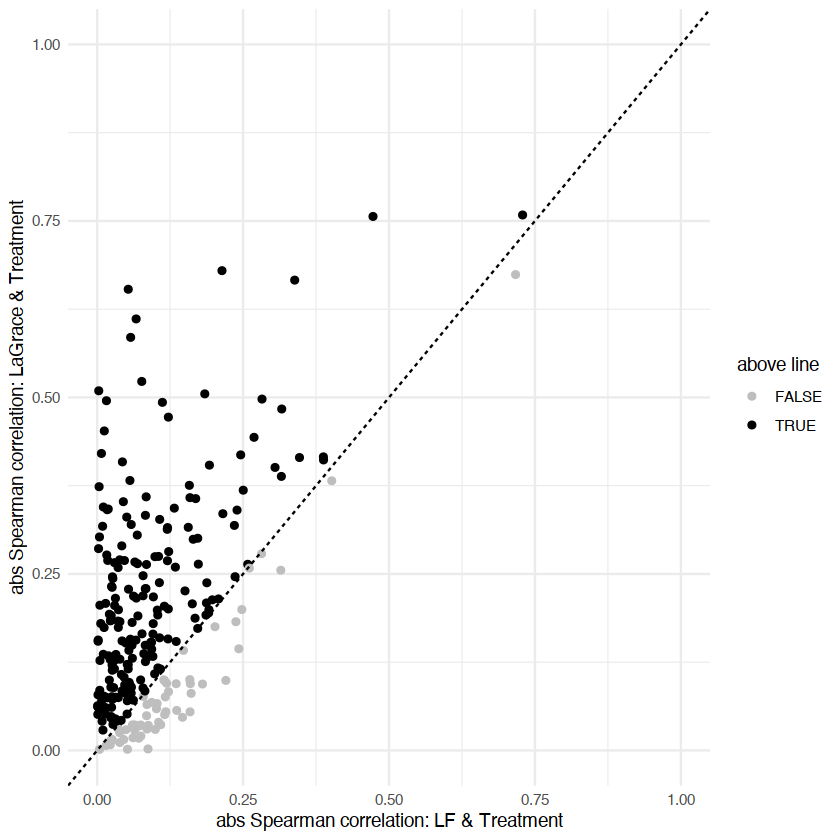

In [131]:
library(ggplot2)

p<-ggplot(Cor_df, aes(abs(Cor_LOVE), abs(Cor_LaGrace))) +
    geom_point() +  # This adds the scatter plot points
    geom_abline(slope = 1, intercept = 0,linetype=2) +  # This adds the line x = y
    xlim(0, 1) + ylim(0, 1) +
    theme_minimal() + xlab('abs Spearman correlation: LF & Treatment') +
    ylab('abs Spearman correlation: LaGrace & Treatment')

# cowplot::save_plot('./scatter_spearman_cor.pdf', p,
# base_aspect_ratio = 1, base_height = 4)

cowplot::save_plot('./scatter_spearman_cor.png', p,
base_aspect_ratio = 1, base_height = 4)
p

p<-ggplot(Cor_df, aes(abs(Cor_LOVE), abs(Cor_LaGrace),color = above_line)) +
    geom_point() +  # This adds the scatter plot points
    geom_abline(slope = 1, intercept = 0,linetype=2) +  # This adds the line x = y
    xlim(0, 1) + ylim(0, 1) +
    theme_minimal() + xlab('abs Spearman correlation: LF & Treatment') +
    ylab('abs Spearman correlation: LaGrace & Treatment') +
    scale_color_manual(values = c( "grey","black")) +
    labs(color='above line') 

# cowplot::save_plot('./scatter_spearman_cor.pdf', p,
# base_aspect_ratio = 1, base_height = 4)

cowplot::save_plot('./scatter_spearman_cor_corlored.png', p,
base_aspect_ratio = 1, base_height = 4)
p

In [ ]:
seurat_obj$treatment <- substring(seurat_obj$treatment_time,6)

p<- VlnPlot(seurat_obj,c('LOVE-53','LOVE-101','LOVE-123'),group.by = "treatment",pt.size = 0,stack = T, fill.by = 'ident', 
flip =T,assay='LOVE') + ylab("LaGrace Score")
p

cowplot::save_plot('./LOVE_vln_LOVE_LF.pdf', p,
base_aspect_ratio = 1, base_height = 4)